In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:17<00:00, 560kB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 117kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 876kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [2]:
# MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [3]:
# CNN模型（使用ResNet架构）
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x += shortcut
        x = self.relu(x)
        return x
class CNNResNet(nn.Module):
    def __init__(self):
        super(CNNResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.resblock1 = ResNetBlock(64, 64)
        self.fc1 = nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.resblock1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [4]:
# RNN模型
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=28, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        # 将输入形状从 [batch_size, 1, 28, 28] 转换为 [batch_size, 28, 28]
        x = x.squeeze(1)  # [batch_size, 28, 28], 移除通道维度
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # 只取最后一个时间步的输出
        x = self.fc(x)
        return x



In [5]:
# Multi-Head Attention模型
class MultiHeadAttentionModel(nn.Module):
    def __init__(self):
        super(MultiHeadAttentionModel, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=28, num_heads=4)
        self.fc = nn.Linear(28, 10)

    def forward(self, x):
        # 将输入形状从 [batch_size, 1, 28, 28] 转换为 [batch_size, 28, 28]
        x = x.squeeze(1)  # 移除通道维度，得到 [batch_size, 28, 28]，即每行是一个时间步
        # 将输入的形状调整为 [28, batch_size, 28]，符合 MultiHeadAttention 的要求
        x = x.permute(1, 0, 2)  # 变为 [seq_len, batch_size, input_size]

        # 使用 MultiheadAttention 进行处理
        x, _ = self.attn(x, x, x)

        # 取最后一个时间步的输出
        x = x[-1, :, :]  # 只取最后一个时间步的输出

        # 通过全连接层输出分类结果
        x = self.fc(x)
        return x



In [6]:
# 训练和评估函数
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [7]:
# 初始化模型，优化器和损失函数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    "MLP": MLP().to(device),
    "CNNResNet": CNNResNet().to(device),
    "RNN": RNN().to(device),
    "Attention": MultiHeadAttentionModel().to(device)
}

criterions = {
    "MLP": nn.CrossEntropyLoss(),
    "CNNResNet": nn.CrossEntropyLoss(),
    "RNN": nn.CrossEntropyLoss(),
    "Attention": nn.CrossEntropyLoss()
}

optimizers = {
    "MLP": optim.Adam(models["MLP"].parameters(), lr=0.001),
    "CNNResNet": optim.Adam(models["CNNResNet"].parameters(), lr=0.001),
    "RNN": optim.Adam(models["RNN"].parameters(), lr=0.001),
    "Attention": optim.Adam(models["Attention"].parameters(), lr=0.001)
}

results = {model_name: {"train_losses": [], "val_losses": [], "train_accs": []} for model_name in models.keys()}


In [8]:
# 训练和评估所有模型
num_epochs = 10
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, trainloader, criterions[model_name], optimizers[model_name], device)
        val_loss, val_acc = evaluate(model, testloader, criterions[model_name], device)

        # 记录数据
        results[model_name]["train_losses"].append(train_loss)
        results[model_name]["val_losses"].append(val_loss)
        results[model_name]["train_accs"].append(train_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")



Training MLP...
Epoch [1/10], Train Loss: 0.3794, Train Acc: 88.94% | Val Loss: 0.2514, Val Acc: 92.50%
Epoch [2/10], Train Loss: 0.1949, Train Acc: 94.22% | Val Loss: 0.1539, Val Acc: 95.42%
Epoch [3/10], Train Loss: 0.1429, Train Acc: 95.77% | Val Loss: 0.1283, Val Acc: 96.29%
Epoch [4/10], Train Loss: 0.1158, Train Acc: 96.51% | Val Loss: 0.1117, Val Acc: 96.74%
Epoch [5/10], Train Loss: 0.0993, Train Acc: 96.97% | Val Loss: 0.1060, Val Acc: 96.82%
Epoch [6/10], Train Loss: 0.0850, Train Acc: 97.41% | Val Loss: 0.0911, Val Acc: 97.28%
Epoch [7/10], Train Loss: 0.0758, Train Acc: 97.67% | Val Loss: 0.1046, Val Acc: 96.67%
Epoch [8/10], Train Loss: 0.0697, Train Acc: 97.86% | Val Loss: 0.0805, Val Acc: 97.64%
Epoch [9/10], Train Loss: 0.0619, Train Acc: 98.06% | Val Loss: 0.0855, Val Acc: 97.43%
Epoch [10/10], Train Loss: 0.0588, Train Acc: 98.09% | Val Loss: 0.0922, Val Acc: 97.15%

Training CNNResNet...
Epoch [1/10], Train Loss: 0.1393, Train Acc: 96.10% | Val Loss: 0.0485, Val Acc

In [9]:
# 绘制训练图表
def plot_results(results):
    for model_name, data in results.items():
        plt.figure(figsize=(12, 5))

        # Train vs Val Loss
        plt.subplot(1, 2, 1)
        plt.plot(data["train_losses"], label="Train Loss")
        plt.plot(data["val_losses"], label="Val Loss")
        plt.title(f'{model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Train Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(data["train_accs"], label="Train Accuracy")
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.show()



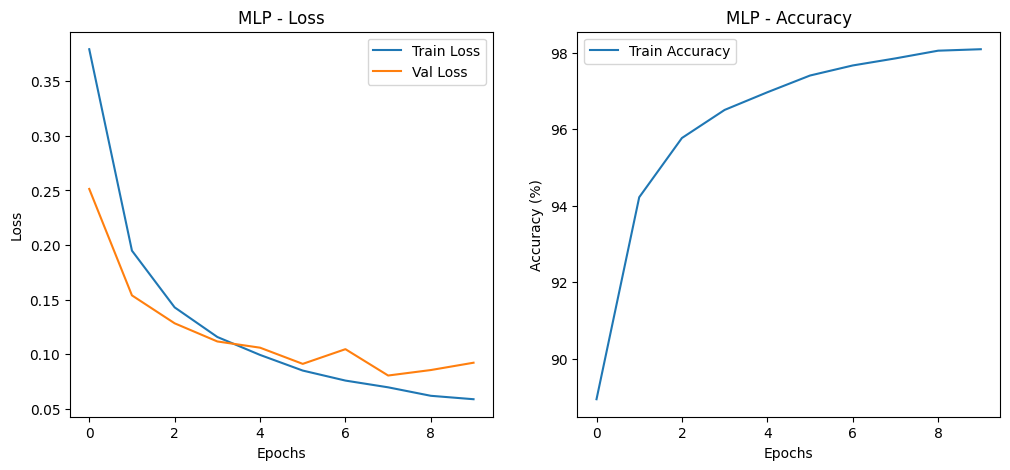

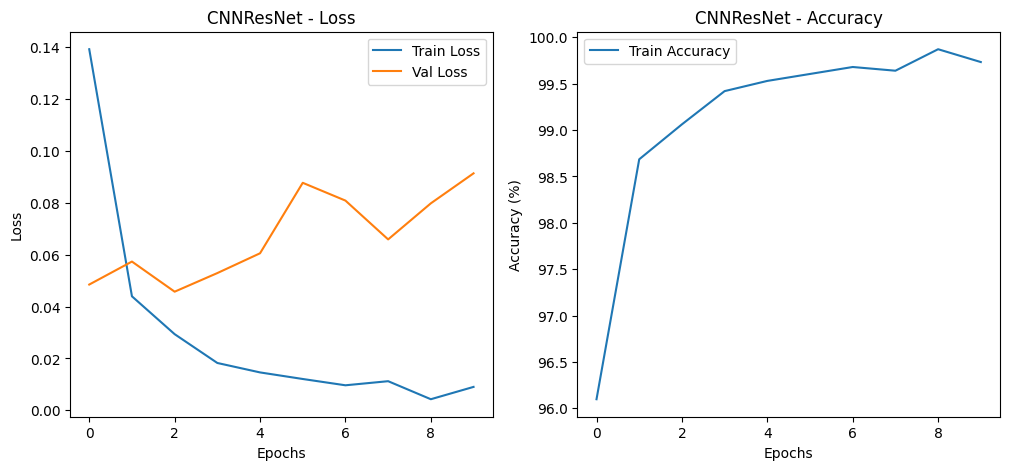

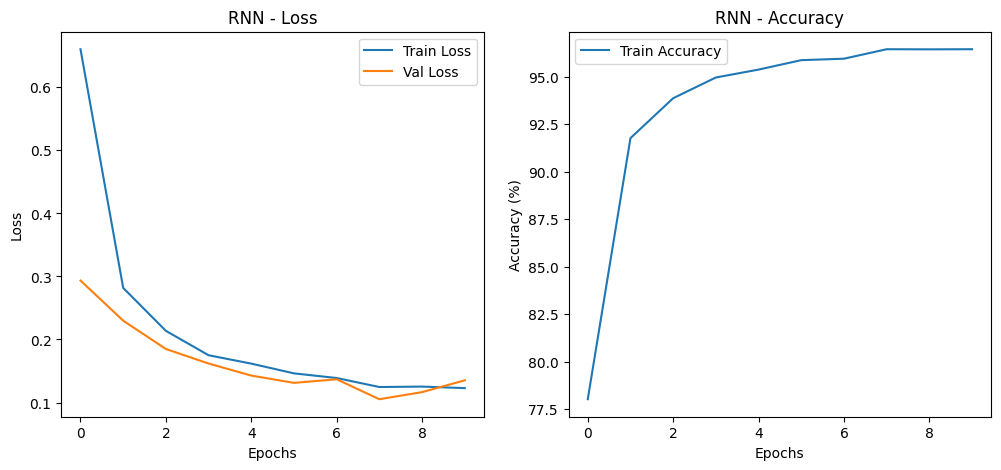

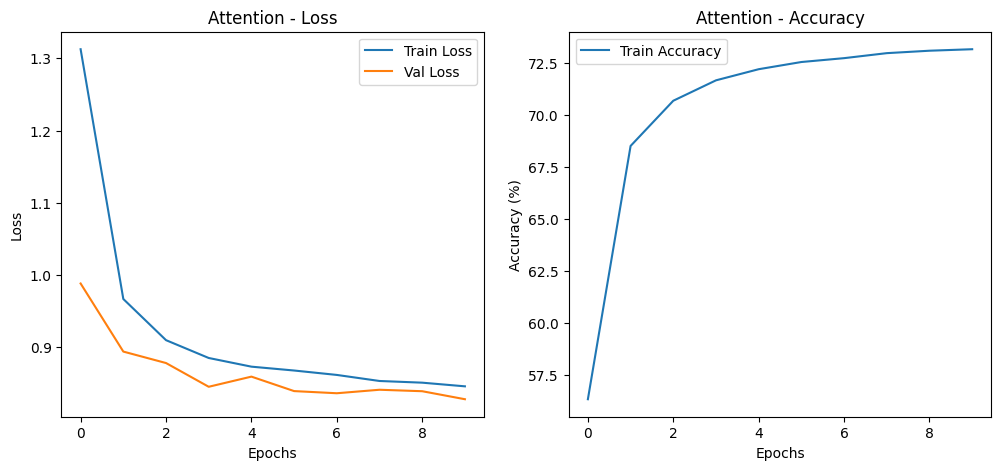

In [10]:
# 绘制所有模型的结果图表
plot_results(results)